In [ ]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.qua import *
from qm import SimulationConfig, LoopbackInterface
from QUA_config_two_sc_qubits import IBMconfig as config
from qm.simulate.credentials import create_credentials
from qua_utils import clip_qua, rand_gauss_moller_box
from videomode import ParameterTable, ParameterValue
from qiskit import pulse
from qiskit.circuit import Parameter, ParameterVector
from qiskit.pulse.library import SymbolicPulse

SymbolicPulse.disable_validation = True
# Open communication with the server.
qop_ip = None
qmm = QuantumMachinesManager(
    host="tyler-263ed49e.dev.quantum-machines.co",
    port=443,
    credentials=create_credentials(),
)
params = ParameterTable({"param1": 3.7, "param2": 4.5})
param_qiskit = ParameterVector("param", 2)
with program() as measureProg:
    var = params.declare_variables()
    ind = declare(int, value=5)
    print(var)
    clip_qua(params.get_parameter("param1"), 2, 4)
    save(var[0], "var0")
    with pulse.build() as sched:
        pulse.play(
            pulse.Drag(
                amp=param_qiskit[0], sigma=0.1, beta=param_qiskit[1], duration=160
            ),
            pulse.DriveChannel(0),
        )
    sched.assign_parameters({param_qiskit: var})
# Simulate the program on the server
# job = qmm.simulate(
#     config,
#     measureProg,
#     SimulationConfig(
#         4000,  # Duration of simulation in units of clock cycles (4 ns)
#         simulation_interface=LoopbackInterface(
#             [("con1", 1, "con1", 1)]
#         ),  # Simulate a loopback from analog output 1 to analog input 1
#     ),
# )

# Fetch the results of the simulation
# res = job.result_handles
# str = res.get("var").fetch_all()["value"]
# str
print(sched)

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
service.save_account()
backend = service.get_backend("ibm_sherbrooke")

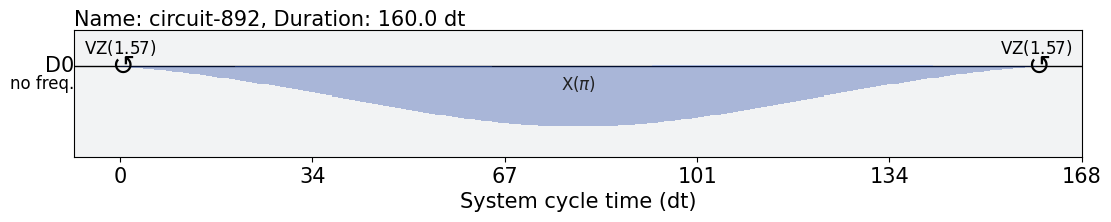

In [59]:
from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
from qiskit import QuantumCircuit, transpile, schedule
import numpy as np

backend = FakeJakartaV2()
qc = QuantumCircuit(1)
qc.rz(np.pi / 2, 0)
qc.x(0)
qc.rz(np.pi / 2, 0)
sched = schedule(qc, backend)
qc.add_calibration("y", [0], sched)
qc.draw("mpl")
qc.clear()
qc.y(0)
qc.draw("mpl")

sched2 = schedule(qc, backend)

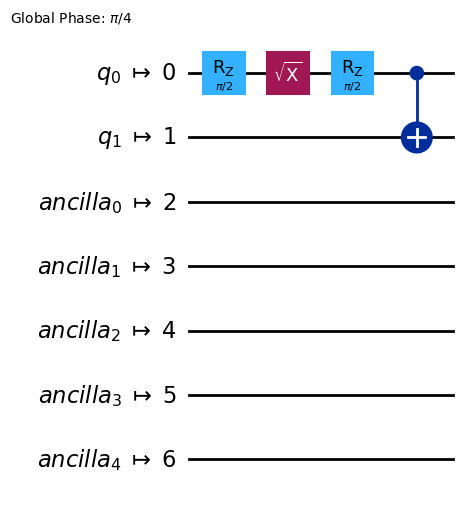

In [8]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc = transpile(qc, backend)
qc.draw("mpl")

In [9]:
from qiskit import schedule

schedule(qc, backend)

Schedule((0, ShiftPhase(-1.5707963268, DriveChannel(0))), (0, ShiftPhase(-1.5707963268, ControlChannel(1))), (0, Play(Drag(duration=160, sigma=40, beta=-1.0522991222950833, amp=0.10071860022027769, angle=0.008331009463217867, name='X90p_d0'), DriveChannel(0), name='X90p_d0')), (160, ShiftPhase(-1.5707963268, DriveChannel(0))), (160, ShiftPhase(1.5707963267948966, DriveChannel(0))), (160, ShiftPhase(-1.5707963268, ControlChannel(1))), (160, ShiftPhase(1.5707963267948966, ControlChannel(1))), (160, Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=0.2012211411684789, angle=-1.5707963267948968, name='Ym_d0'), DriveChannel(0), name='Ym_d0')), (160, Play(Drag(duration=160, sigma=40, beta=-0.968549607705977, amp=0.09683699950387357, angle=0.02080553739417185, name='X90p_d1'), DriveChannel(1), name='X90p_d1')), (320, Play(GaussianSquare(duration=368, sigma=64, width=112, amp=0.11225338480773679, angle=0.015092743952178559, name='CR90p_d1_u0'), DriveChannel(1), name='CR90p_d1_u0'

In [26]:
cx.calibration.instructions[3][1].pulse.name

In [39]:
from qiskit import pulse
from qiskit.circuit import QuantumCircuit, Parameter

a = Parameter("a")
p = pulse.Drag(amp=a, sigma=0.1, beta=0.5, duration=160)
for key, val in p.parameters.items():
    print(key, val)

In [33]:
cst_p = pulse.Constant(160, 0.5)
cst_p

In [35]:
cst_p.duration

In [47]:
from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
from qiskit.circuit import QuantumCircuit
from qiskit import transpile, schedule

backend = FakeJakartaV2()
backend.target["measure"][(0,)].calibration.draw()

In [48]:
backend.target["measure"][(0,)].calibration

In [49]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
transpiled_qc = transpile(qc, backend)
sched = schedule(transpiled_qc, backend)
sched.draw()

In [50]:
sched

In [4]:
from quam.components import *
from quam.examples.superconducting_qubits import Transmon, QuAM

machine = QuAM()  #

num_qubits = 2
for idx in range(num_qubits):
    # Create transmon qubit component
    transmon = Transmon(id=idx)

    # Add xy drive line channel
    transmon.xy = IQChannel(
        opx_output_I=("con1", 3 * idx + 3),
        opx_output_Q=("con1", 3 * idx + 4),
        frequency_converter_up=FrequencyConverter(
            mixer=Mixer(),
            local_oscillator=LocalOscillator(power=10, frequency=6e9),
        ),
        intermediate_frequency=100e6,
    )

    # Add transmon flux line channel
    transmon.z = SingleChannel(opx_output=("con1", 3 * idx + 5))

    # Add resonator channel
    transmon.resonator = InOutIQChannel(
        id=idx,
        opx_output_I=("con1", 3 * idx + 1),
        opx_output_Q=("con1", 3 * idx + 2),
        opx_input_I=("con1", 1),
        opx_input_Q=(
            "con1",
            2,
        ),
        frequency_converter_up=FrequencyConverter(
            mixer=Mixer(), local_oscillator=LocalOscillator(power=10, frequency=6e9)
        ),
    )
    machine.qubits[transmon.name] = transmon

In [5]:
from quam.components.pulses import GaussianPulse

# Create a Gaussian pulse
gaussian_pulse = GaussianPulse(length=20, amplitude=0.2, sigma=3)

# Attach the pulse to the XY channel of the first qubit
machine.qubits

{'q0': Transmon(id=0, xy=IQChannel(operations={}, id=None, digital_outputs={}, opx_output_I=('con1', 3), opx_output_Q=('con1', 4), opx_output_offset_I=None, opx_output_offset_Q=None, frequency_converter_up=FrequencyConverter(local_oscillator=LocalOscillator(frequency=6000000000.0, power=10), mixer=Mixer(local_oscillator_frequency=6000000000.0, intermediate_frequency=100000000.0, correction_gain=0, correction_phase=0), gain=None), intermediate_frequency=100000000.0), z=SingleChannel(operations={}, id=None, digital_outputs={}, opx_output=('con1', 5), filter_fir_taps=None, filter_iir_taps=None, opx_output_offset=None, intermediate_frequency=None), resonator=InOutIQChannel(operations={}, id=0, digital_outputs={}, opx_output_I=('con1', 1), opx_output_Q=('con1', 2), opx_output_offset_I=None, opx_output_offset_Q=None, frequency_converter_up=FrequencyConverter(local_oscillator=LocalOscillator(frequency=6000000000.0, power=10), mixer=Mixer(local_oscillator_frequency=6000000000.0, intermediate_f

In [17]:
list(machine.qubits.values())

[Transmon(id=0, xy=IQChannel(operations={'X90': GaussianPulse(length=20, id=None, digital_marker=None, amplitude=0.2, sigma=3, axis_angle=None, subtracted=True)}, id=None, digital_outputs={}, opx_output_I=('con1', 3), opx_output_Q=('con1', 4), opx_output_offset_I=None, opx_output_offset_Q=None, frequency_converter_up=FrequencyConverter(local_oscillator=LocalOscillator(frequency=6000000000.0, power=10), mixer=Mixer(local_oscillator_frequency=6000000000.0, intermediate_frequency=100000000.0, correction_gain=0, correction_phase=0), gain=None), intermediate_frequency=100000000.0), z=SingleChannel(operations={}, id=None, digital_outputs={}, opx_output=('con1', 5), filter_fir_taps=None, filter_iir_taps=None, opx_output_offset=None, intermediate_frequency=None), resonator=InOutIQChannel(operations={}, id=0, digital_outputs={}, opx_output_I=('con1', 1), opx_output_Q=('con1', 2), opx_output_offset_I=None, opx_output_offset_Q=None, frequency_converter_up=FrequencyConverter(local_oscillator=Local

In [4]:
machine.generate_config()

{'version': 1,
 'controllers': {'con1': {'analog_outputs': {3: {'offset': 0.0},
    4: {'offset': 0.0},
    5: {'offset': 0.0},
    1: {'offset': 0.0},
    2: {'offset': 0.0},
    6: {'offset': 0.0},
    7: {'offset': 0.0},
    8: {'offset': 0.0}},
   'digital_outputs': {},
   'analog_inputs': {1: {'offset': 0.0}, 2: {'offset': 0.0}}}},
 'elements': {'q0.xy': {'operations': {'X90': 'q0.xy.X90.pulse'},
   'intermediate_frequency': 100000000.0,
   'mixInputs': {'I': ('con1', 3),
    'Q': ('con1', 4),
    'mixer': 'q0.xy.mixer',
    'lo_frequency': 6000000000.0}},
  'q0.z': {'operations': {}, 'singleInput': {'port': ('con1', 5)}},
  'IQ0': {'operations': {},
   'intermediate_frequency': 0.0,
   'mixInputs': {'I': ('con1', 1),
    'Q': ('con1', 2),
    'mixer': 'IQ0.mixer',
    'lo_frequency': 6000000000.0},
   'smearing': 0,
   'time_of_flight': 24,
   'outputs': {'out1': ('con1', 1), 'out2': ('con1', 2)}},
  'q1.xy': {'operations': {},
   'intermediate_frequency': 100000000.0,
   'mixInp

In [5]:
quam = QuAM.load("quam_state.json")
quam

AttributeError: module 'quam.components.pulses' has no attribute 'DragPulseCosine'

In [25]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qiskit.primitives import BackendEstimatorV2, BackendEstimator
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import SparsePauliOp

param = Parameter("param")
param_vec = ParameterVector("param", 2)
qc = QuantumCircuit(2)
qc.rx(param, 0)
qc.ry(param_vec[0], 0)
qc.rz(param_vec[1], 0)

obs = SparsePauliOp.from_list([("XX", 3.0), ("YY", 2.0)])
backend = GenericBackendV2(2)
estimator = BackendEstimatorV2(backend=backend)
estimatorv1 = BackendEstimator(backend=backend)
job = estimator.run(
    [(qc, obs, {param: [0.5, 0.3], param_vec: [[0.3, 0.7], [0.2, 0.4]]})]
)
jobv1 = estimatorv1.run([qc], observables=[obs], parameter_values=[0.5, 0.3, 0.2])
result = job.result()
resultv1 = jobv1.result()

In [54]:
result[0].data.evs

In [46]:
qc.parameters

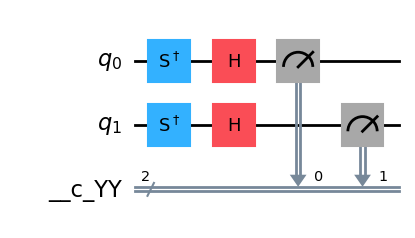

In [37]:
estimatorv1.preprocessed_circuits[0][1][1].draw("mpl")

In [41]:
from qiskit.transpiler import Layout
from qiskit import QuantumCircuit, QuantumRegister

qr = QuantumRegister(2)
layout = Layout({qr[0]: 2, qr[1]: 1})
layout.get_physical_bits()

{2: Qubit(QuantumRegister(2, 'q14'), 0),
 1: Qubit(QuantumRegister(2, 'q14'), 1)}